# **Project: Multitask Learning for Geometric Shape Classification and Counting**

## 1. Overview

In this project, you will design, implement, and evaluate a **multitask neural network** that performs **two tasks simultaneously**:

1. **Classification** – identify which pair of geometric shape types appears in a 28×28 binary image (135 possible configurations).
2. **Regression** – predict how many shapes of each type are present (6 regression targets).

This project focuses on **multi-task learning**, i.e., using one shared model to learn several related tasks at once. You will compare how adding an auxiliary task affects performance and training dynamics.

---

## 2. Dataset

You will use the **Geometric Shape Numbers (GSN)** dataset:

```bash
!wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip
```

This will create a directory `data/` containing:

* **10,000 images** (28×28x1, grayscale)
* **labels.csv** – counts of each of six shape types per image

Each image contains exactly **two types** of geometric figures (out of six) and **10 shapes total**.

**Shape classes:**

| Index | Shape type     |
| ----: | -------------- |
|     0 | square         |
|     1 | circle         |
|     2 | triangle up    |
|     3 | triangle right |
|     4 | triangle down  |
|     5 | triangle left  |

Example row from `labels.csv`:

```
name,squares,circles,up,right,down,left
img_00000.png,0,0,0,4,0,6
```

Here, the image contains **4 right-pointing triangles** and **6 left-pointing triangles**.

**Split:**

* Training: first 9,000 samples
* Validation: last 1,000 samples

Examples:
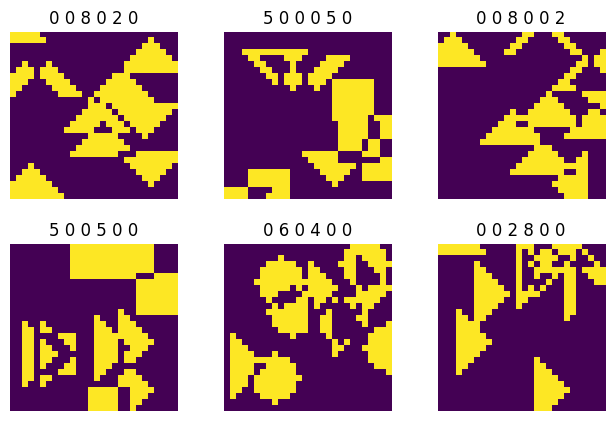

---

## 3. Tasks and objectives

You must design a **multitask deep learning system** that:

1. **Classifies** each image into one of **135 possible configurations**, representing:

   * which **two shape classes** appear, and
   * how their counts (1–9) sum to 10.

   → Example: "3 circles + 7 squares" is one configuration class.

2. **Regresses** the number of shapes of each type (a 6-dimensional real-valued output).

3. Combines both objectives in a **joint loss** function (Hint: losses are implemented in PyTorch):


$$ Loss = \text{NLLLoss(classification)} + \lambda_{\text{cnt}} \cdot \text{SmoothL1Loss(regression)}
$$

---

## 4. Model requirements

### Architecture constraints

You must use **exactly this feature extractor (backbone)**:

```python
nn.Sequential(
    nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(64 * 28 * 28, 256), nn.ReLU()
)
```

Then add **two separate heads**:

* `head_cls`: outputs log-probabilities for 135 classes
* `head_cnt`: outputs 6 regression values (counts)

The model must return two outputs: `(log_probs, counts)`.

You may add dropout or batch normalization inside the heads, **but you must not modify the backbone**.

---

## 5. Training setup

* Optimizer: **Adam**, learning rate = 1e-3
* Epochs: up to **100** (use **early stopping**)
* Batch sizes: **64** (train), **1000** (validation)
* Device: GPU allowed for Notebook, but your **final code must run on GPU within ~30 minutes**
* Random seed: set `torch.manual_seed(1)` for reproducibility
* Split: **exactly 9,000 train / 1,000 validation**


---

## 6. Data preprocessing and augmentation

You must implement a **PyTorch `Dataset` class** that:

* Reads `labels.csv`
* Loads the corresponding image (from `data/`)
* Returns both:
  * the image (as a tensor)
  * the labels (counts for 6 shapes)
* Optionally applies transformations

### Required augmentations

You must implement **at least three** of the following:

1. Random horizontal flip
2. Random vertical flip
3. Random 90° rotation (must correctly rotate orientation labels: up → right → down → left)
4. Random brightness/contrast (mild)
5. Gaussian noise
6. Random erasing (small areas only)


---

## 7. Evaluation metrics

Implement and report the following metrics on the validation set:

### (a) **Classification (135-way)**

* Top-1 accuracy
* Macro F1-score
* Per-pair accuracy (aggregate by unordered shape pair, e.g. {circle, up})

### (b) **Regression (6-D counts)**

* RMSE per class and overall
* MAE per class and overall

Also plot:

* Training and validation losses
* Validation accuracy and RMSE over epochs

**Important**: This task is not about finding the best architecture; we expect at least 50% accuracy, but achieving results higher than that will not affect the grade for the assignment**.


---

## 8. Experiments and analysis

You must train and compare **three model settings**:

| Setting | Description                                      |
| :------ | :----------------------------------------------- |
| 1       | **Classification-only:** λ_cnt = 0               |
| 2       | **Regression-only:** classification loss ignored |
| 3       | **Multitask:** λ_cnt = with your choose          |

For each experiment:

* Train until early stopping
* Record loss, accuracy, RMSE, and runtime
* Compare results and explain how λ influences learning
* Discuss whether multitask learning improves the main tasks


---

## 9. Final deliverables

You must submit .zip project with:

1. **Code** (`.ipynb` or `.py`) that:

   * Downloads and extracts the dataset
   * Defines dataset, dataloaders, model, loss, training loop, evaluation, and plotting
   * Can run start-to-end without interaction, and finishes within 30 minutes on Colab T4 GPUs
   * Includes three experiment configurations

2. **Report (2–4 pages, PDF)** including:
   * Section on (EDA) Exploratory Data Analysis in your report: no more than 3 graphs or tables describing the data set.
   * Model architecture
   * Description and justification of augmentations
   * Results table (loss, accuracy, RMSE for all runs)
   * Learning curves
   * Discussion on multitask effects

3. **README.md**:

   * Link to Colab version of task for fast replication.
   * Approximate runtime and resource requirements

---

## 10. Grading rubric

Component	Description	Points
1. Implementation correctness	Correct use of the fixed backbone, two-headed model, and proper training loop (classification + regression).	30%
2. Data & augmentations	Proper dataset loading, preprocessing, and at least three augmentations with brief justification.	20%
3. Evaluation & experiments	Correct computation of metrics (accuracy, F1, RMSE) and completion of all three λ configurations (λ=0, regression-only, your choice λ).	30%
4. Report & analysis
A clear separation of concerns (e.g. headers in notebooks, modules in code) and concise 2–4 page report with results tables, learning curves, confusion matrix, and short discussion on multitask effects and error examples.
20%

###### Readability and modularity will be considered within each grading component. Clear structure (headers in notebooks, docstrings, modular code) significantly improves evaluation speed. Emphasize using clear headers to help reviewers navigate efficiently.
---

In [1]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-25 17:18:44--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-25 17:18:45--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.02s   

2025-11-25 17:18:45 (348 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



Train Epoch: 0, [0/8000 images (0%)] loss 3.998734 (cls 5.066091, reg 1.508233)
Train Epoch: 0, [6400/8000 images (80%)] loss 3.282898 (cls 4.123425, reg 1.321671)
=== Validation===
Avg joint loss: 45.211395
Top-1 accuracy: 0.0085
Macro F1: 0.0001
Per-pair recall:
  square circle  : 0.0000
  square up      : 0.0000
  square right   : 0.0000
  square down    : 0.0000
  square left    : 0.0000
  circle up      : 0.0000
  circle right   : 0.0000
  circle down    : 0.0000
  circle left    : 0.0000
  up right       : 0.0000
  up down        : 0.0000
  up left        : 0.0000
  right down     : 0.0000
  right left     : 0.1189
  down left      : 0.0000
Regression MAE per class: [3.143923759460449, 17.225433349609375, 1.8083882331848145, 24.134017944335938, 6.485063076019287, 28.66265106201172]
Regression RMSE per class: [3.336488723754883, 17.438051223754883, 2.2199196815490723, 24.255327224731445, 6.875723361968994, 28.7758846282959]
Overall MAE: 13.5766, Overall RMSE: 17.2424
Train Epoch: 

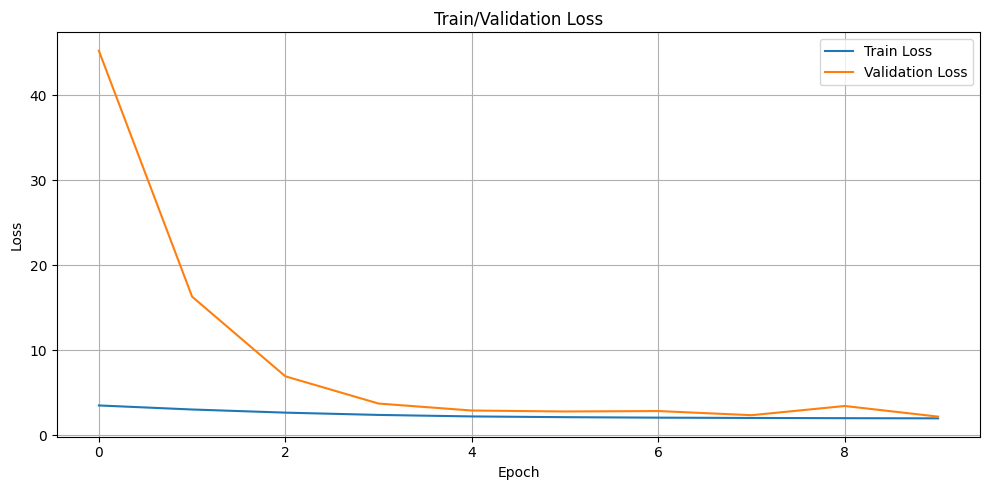

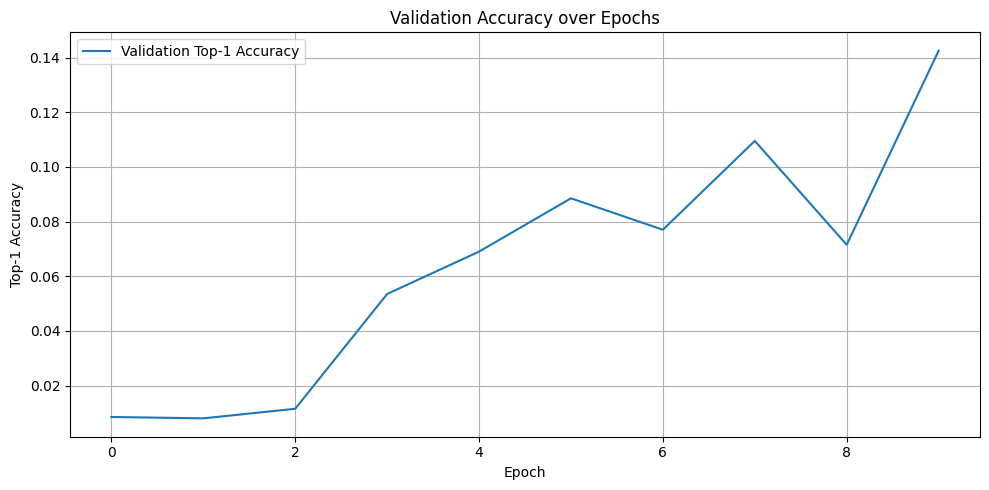

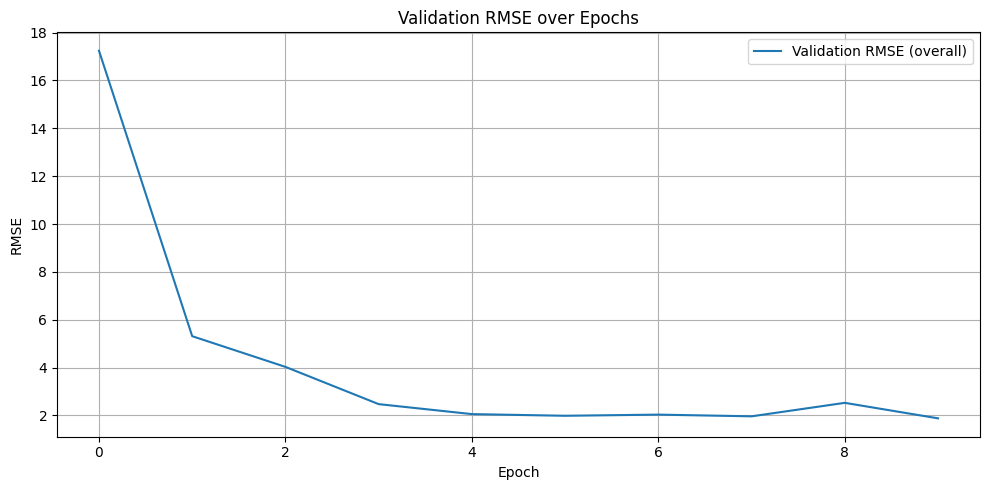

In [10]:
from pathlib import Path
from PIL import Image
import torch
import torch.nn
from torch import Tensor
from typing import cast
from torchvision.transforms import v2
import numpy as np
import torchvision.transforms as T
import PIL
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1)

directory_in_str = "data"
class RandomHorizontalFlip(torch.nn.Module): # here define it for both the img and the label, which itsel is just a list
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img, label: np.ndarray):
        imgNew = img.copy()
        labelNew = label.copy()
        if torch.rand(1) < self.p:
            imgNew =  T.functional.hflip(imgNew)
            placeHold = labelNew[5]
            labelNew[5] = labelNew[3]
            labelNew[3] = placeHold

        return imgNew, labelNew


class RandomVerticalFlip(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img, label: np.ndarray):
        imgNew = img.copy()
        labelNew = label.copy()
        if torch.rand(1) < self.p:

            imgNew =  T.functional.vflip(imgNew)
            placeHold = labelNew[2]
            labelNew[2] = labelNew[4]
            labelNew[4] = placeHold

        return imgNew, labelNew

class Random90DegFlip(torch.nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img, label: np.ndarray):
        imgNew = img.copy()
        labelNew = label.copy()
        if torch.rand(1) < self.p:
            imgNew =  T.functional.rotate(imgNew,90)
            plcHoldUp = labelNew[2]
            plcHolLeft = labelNew[5]
            plcHolDown = labelNew[4]
            plcHolRight = labelNew[3]

            labelNew[2] = plcHolLeft # 2 becomes 5
            labelNew[3] = plcHoldUp # 3 becomes 2
            labelNew[4] = plcHolRight # 4 becomes 3
            labelNew[5] = plcHolDown # 5 becomes 4
        return imgNew, labelNew


indexDict = {
    "01":0,
    "02":1,
    "03":2,
    "04":3,
    "05":4,
    "12":5,
    "13":6,
    "14":7,
    "15":8,
    "23":9,
    "24":10,
    "25":11,
    "34":12,
    "35":13,
    "45":14
}

valDict = {
    "19":0,
    "28":1,
    "37":2,
    "46":3,
    "55":4,
    "64":5,
    "73":6,
    "82":7,
    "91":8,
}

pairDict = {
    0:"square circle",
    1:"square up",
    2:"square right",
    3:"square down",
    4:"square left",
    5:"circle up",
    6:"circle right",
    7:"circle down",
    8:"circle left",
    9:"up right",
    10:"up down",
    11:"up left",
    12:"right down",
    13:"right left",
    14:"down left"

}

def listToNum(y):
  # here y is [0,0,3,7,0,0] for example
  val1,val2,i1,i2 = -1,-1,-1,-1
  for i in range(6):
    if y[i] != 0:
      if val1 == -1:
        val1 = y[i]
        i1 = i
      else:
        val2 = y[i]
        i2 = i
  ixPair = str(int(i1)) + str(int(i2))
  ixVal = indexDict[ixPair]

  valPair = str(int(val1)) + str(int(val2))
  valVal = valDict[valPair]
  finalIx = ixVal * 9 + valVal


  return finalIx

def numToPair(y):
  valIndex = y % 9
  ixIndex = (y - valIndex) / 9


  return int(ixIndex)

def aggregateAccuraciesPerPair(TP,FP,TN,FN):
  pTP,pFP,pTN,pFN = [0]*15,[0]*15,[0]*15,[0]*15
  pairAccuracies = [0] *15
  for i in range(135):
    pairIndex = numToPair(i)
    pTP[pairIndex] += TP[i]
    pFP[pairIndex] += FP[i]
    pTN[pairIndex] += TN[i]
    pFN[pairIndex] += FN[i]

  print("TP,FP,TN,FN: ",pTP[0],pFP[0],pTN[0],pFN[0])
  pairAccuracies = [tp + tn / (tp + fp + tn + fn) for tp,fp,tn,fn in zip(pTP,pFP,pTN,pFN)]
  return pairAccuracies


class MyDataset(torch.utils.data.Dataset):
  def __init__(self,X,Y):
    self.X = X
    self.Y = Y
    self.Random90DegFlip = Random90DegFlip()
    self.RandomVerticalFlip = RandomVerticalFlip()
    self.RandomHorizontalFlip = RandomHorizontalFlip()
    self.gausNoise = v2.GaussianNoise()
    self.colorJit = v2.ColorJitter()
    self.erase = v2.RandomErasing()
  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    X,Yr = self.X[idx], self.Y[idx]
    X,Yr = self.Random90DegFlip(X,Yr)
    X,Yr = self.RandomVerticalFlip(X,Yr)
    X,Yr = self.RandomHorizontalFlip(X,Yr)
    X = T.functional.to_tensor(X)

    X = self.gausNoise(X)
    X = self.colorJit(X)
    X = self.erase(X)
    Yc = listToNum(Yr)
    Yr,Yc = torch.tensor(Yr), torch.tensor(Yc)
    return X,Yc,Yr


def tensorToPil(image: Tensor) -> PIL.Image.Image:
  img = T.functional.to_pil_image(image)
  return img

class ModelCombined(torch.nn.Module):
    def __init__(self, clsWeight: float = 0.7, regWeight: float = 0.3):
        super().__init__()
        # fixed backbone (same as before)
        self.bb = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, stride=1, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, 3, stride=1, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=1, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, stride=1, padding=1), torch.nn.ReLU(),
            torch.nn.Flatten(start_dim=1),
            torch.nn.Linear(64 * 28 * 28, 256), torch.nn.ReLU()
        )
        # classification head
        self.classPart = torch.nn.Sequential(
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 135),
            torch.nn.LogSoftmax(dim=1)
        )
        # regression head
        self.regPart = torch.nn.Sequential(
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 6),
        )
        # weights for the joint loss
        self.clsWeight = float(clsWeight)
        self.regWeight = float(regWeight)

    def forward(self, x):
        feat = self.bb(x)
        return self.classPart(feat), self.regPart(feat)


def trainCombined(model, device, trainLoader, optimizer, epoch, logInterval):
    model.train()
    lossSum = 0
    for batchIdx, (data, targetC, targetR) in enumerate(trainLoader):
        data = data.to(device)
        targetC = targetC.to(device).long()
        targetR = targetR.to(device).float()

        optimizer.zero_grad()
        outC, outR = model(data)

        lossC = torch.nn.functional.nll_loss(outC, targetC)
        lossR = torch.nn.functional.smooth_l1_loss(outR, targetR)

        loss = model.clsWeight * lossC + model.regWeight * lossR
        lossSum += loss.item() * data.size(0)
        loss.backward()
        optimizer.step()

        if batchIdx % logInterval == 0:
            done = batchIdx * data.size(0)
            total = len(trainLoader.dataset)
            print(
                f"Train Epoch: {epoch}, [{done}/{total} images ({done / total:.0%})] "
                + f"loss {loss.item():.6f} (cls {lossC.item():.6f}, reg {lossR.item():.6f})"
            )
    lossSum /= len(trainLoader.dataset)
    return lossSum


def testCombined(model, device, valLoader):
    model.eval()
    eps = 1e-8 # to prevent division by zero(inspiration from Marek Muchas lecture about Batch Norm)
    numClasses = 135


    totalSamples = 0
    lossSum = 0.0
    correctTop1 = 0

    # classification
    TP = [0] * numClasses
    FP = [0] * numClasses
    FN = [0] * numClasses

    # regression
    sumAbs = 0
    sumSq = 0

    with torch.no_grad():
        for data, targetC, targetR in valLoader:
            data = data.to(device)
            targetC = targetC.to(device).long()
            targetR = targetR.to(device).float()

            batchSize = targetC.size(0)
            totalSamples += batchSize

            outC, outR = model(data)

            lossC = torch.nn.functional.nll_loss(outC, targetC, reduction="mean")
            lossR = torch.nn.functional.smooth_l1_loss(outR, targetR, reduction="mean")
            jointLoss = model.clsWeight * lossC + model.regWeight * lossR
            lossSum += jointLoss.item() * batchSize

            preds = outC.argmax(dim=1)
            correctTop1 += (preds == targetC).sum().item()

            # accumulate TP/FP/FN per class
            for c in range(numClasses):
                predC = (preds == c)
                trueC = (targetC == c)
                tp = (predC & trueC).sum().item()
                fp = (predC & ~trueC).sum().item()
                fn = (~predC & trueC).sum().item()
                TP[c] += tp
                FP[c] += fp
                FN[c] += fn

            absErr = torch.abs(outR - targetR)
            sqErr = (outR - targetR) ** 2
            if sumAbs is None:
                sumAbs = absErr.sum(dim=0).cpu()
                sumSq = sqErr.sum(dim=0).cpu()
            else:
                sumAbs += absErr.sum(dim=0).cpu()
                sumSq += sqErr.sum(dim=0).cpu()

    avgLoss = lossSum / (totalSamples + eps)
    top1 = correctTop1 / (totalSamples + eps)

    precisionList = [TP[i] / (TP[i] + FP[i] + eps) for i in range(numClasses)]
    recallList = [TP[i] / (TP[i] + FN[i] + eps) for i in range(numClasses)]
    f1PerClass = [2 * precisionList[i] * recallList[i] / (precisionList[i] + recallList[i] + eps) for i in range(numClasses)]
    macroF1 = sum(f1PerClass) / numClasses

    pairTP = [0] * 15
    pairFN = [0] * 15
    for i in range(numClasses):
        pidx = numToPair(i)
        pairTP[pidx] += TP[i]
        pairFN[pidx] += FN[i]
    recallPerPair = [pairTP[i] / (pairTP[i] + pairFN[i] + eps) for i in range(15)]

    sumAbs = sumAbs.float()
    sumSq = sumSq.float()
    maePerClass = (sumAbs / (totalSamples + eps)).tolist()       # length 6
    rmsePerClass = torch.sqrt(sumSq / (totalSamples + eps)).tolist()
    maeOverall = float(sum(maePerClass) / len(maePerClass))
    rmseOverall = float(torch.sqrt((sumSq / (totalSamples + eps)).mean()).item())

    print("=== Validation===")
    print(f"Avg joint loss: {avgLoss:.6f}")
    print(f"Top-1 accuracy: {top1:.4f}")
    print(f"Macro F1: {macroF1:.4f}")
    print("Per-pair recall:")
    for i in range(15):
        print(f"  {pairDict[i]:15s}: {recallPerPair[i]:.4f}")

    print(f"Regression MAE per class: {maePerClass}")
    print(f"Regression RMSE per class: {rmsePerClass}")
    print(f"Overall MAE: {maeOverall:.4f}, Overall RMSE: {rmseOverall:.4f}")
    print("===========================")

    return {
        "loss": avgLoss,
        "top1": top1,
        "macroF1": macroF1,
        "recallPerPair": recallPerPair,
        "maePerClass": maePerClass,
        "rmseOverall": rmseOverall,
        "rmsePerClass": rmsePerClass,
    }

pathlist = Path(directory_in_str).glob('**/*.png')
X = [0] * 10000

for path in pathlist: # let's extract each of the 10000 images into one big tensor, our sample dataset, X
    path_in_str = str(path)
    index = path_in_str[-9:-4]

    index = int(index)

    img = Image.open(path_in_str).convert("L")
    X[index] = img # as such, image 00000 resides in X[0]



csvFile = pd.read_csv("data/labels.csv")
Y = csvFile.values[:,1:].astype(np.float32)

XTrainReg = X[:8000] # these are of the form, 8000 images
YTrainReg = Y[:8000]


XValReg = X[8000:]
YValReg = Y[8000:]


XTrainClass = XTrainReg.copy()
YTrainClass = YTrainReg.copy()

XValClass = XValReg.copy()
YValClass = YValReg.copy()


trainDatasetAll = MyDataset(XTrainReg,YTrainReg)
valDatasetAll = MyDataset(XValReg,YValReg)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
batchSize = 64
testBatchSize = 2000

train_loaderAll = torch.utils.data.DataLoader(trainDatasetAll, batch_size=batchSize, **kwargs)
test_loaderAll = torch.utils.data.DataLoader(valDatasetAll, batch_size=testBatchSize, **kwargs)

model = ModelCombined().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainLosses = []
valLosses = []
valTop1s = []
valRMSEs = []

for epoch in range(10):
    trainLoss = trainCombined(model, device, train_loaderAll, optimizer, epoch, logInterval=100)
    metrics = testCombined(model, device, test_loaderAll)

    trainLosses.append(trainLoss)
    valLosses.append(metrics["loss"])
    valTop1s.append(metrics["top1"])
    valRMSEs.append(metrics["rmseOverall"])


epochs = list(range(10))

plt.figure(figsize=(10, 5))
plt.plot(epochs, trainLosses, label="Train Loss")
plt.plot(epochs, valLosses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, valTop1s, label="Validation Top-1 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, valRMSEs, label="Validation RMSE (overall)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Validation RMSE over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
